# Simple Plotting


In [21]:
RESULTS_PATH = "/tmp/results/default"

PLOT_ALL_SEEDS = False
# Full sweep
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
MODELS_TO_PLOT = ["gpt2", "gpt2-medium"]
# Minimal sweep
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large"]


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display

import os
import glob
import json

In [23]:
records = []
for result_filename in glob.glob(os.path.join(RESULTS_PATH, "**/results_summary.json"), recursive=True):
    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
    config = json.load(open(config_file, "r"))
    if config["model_size"] not in MODELS_TO_PLOT:
        continue
    if 'seed' not in config:
        config['seed'] = 0
    record = config.copy()
    if 'weak_model' in config:
        for k in record['weak_model']:
            if k == 'model_size':
                assert record['weak_model'][k] == record['weak_model_size']
            record['weak_' + k] = record['weak_model'][k]
        del record['weak_model']
    record.update(json.load(open(result_filename)))
    records.append(record)

df = pd.DataFrame.from_records(records).sort_values(['ds_name', 'model_size'])

In [14]:
df

,batch_size,max_ctx,ds_name,loss,n_docs,n_test_docs,model_size,lr,optim,epochs,...,weak_n_docs,weak_n_test_docs,weak_lr,weak_optim,weak_epochs,weak_seed,weak_train_with_dropout,weak_linear_probe,weak_lr_schedule,weak_eval_every
0,32,1024,boolq,xent,20000,10000,gpt2,0.00005,adam,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,1024,boolq,xent,20000,10000,gpt2,0.00005,adam,2,...,20000.0,10000.0,0.00005,adam,2.0,0.0,False,False,cosine_anneal,1000000.0
1,32,1024,boolq,xent,20000,10000,gpt2-medium,0.00005,adam,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,1024,boolq,xent,20000,10000,gpt2-medium,0.00005,adam,2,...,20000.0,10000.0,0.00005,adam,2.0,0.0,False,False,cosine_anneal,1000000.0


In [16]:
df.columns

Index(['batch_size', 'max_ctx', 'ds_name', 'loss', 'n_docs', 'n_test_docs',
       'model_size', 'lr', 'optim', 'epochs', 'seed', 'train_with_dropout',
       'linear_probe', 'lr_schedule', 'eval_every', 'accuracy',
       'weak_model_size', 'weak_batch_size', 'weak_max_ctx', 'weak_ds_name',
       'weak_loss', 'weak_n_docs', 'weak_n_test_docs', 'weak_lr', 'weak_optim',
       'weak_epochs', 'weak_seed', 'weak_train_with_dropout',
       'weak_linear_probe', 'weak_lr_schedule', 'weak_eval_every'],
      dtype='object')

Dataset: boolq (seed: None)


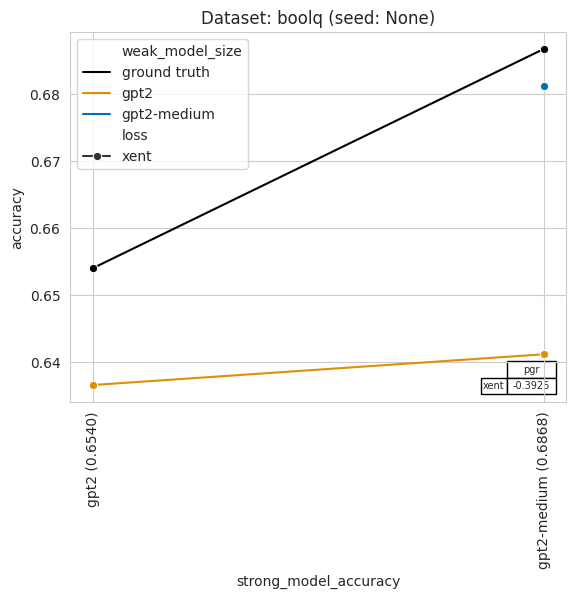

In [24]:
datasets = df.ds_name.unique()
for dataset in datasets:
    cur_df = df[(df.ds_name == dataset)].copy()
    base_accuracies = cur_df[cur_df['weak_model_size'].isna()].groupby('model_size').agg({'accuracy': 'mean', 'seed': 'count'}).sort_values('accuracy')
    base_accuracy_lookup = base_accuracies['accuracy'].to_dict()
    base_accuracies = base_accuracies.reset_index()

    cur_df['strong_model_accuracy'] = cur_df['model_size'].apply(lambda x: base_accuracy_lookup[x])
    cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_accuracy'] = cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_size'].apply(lambda x: base_accuracy_lookup[x])

    # Exclude cases where the weak model is better than the strong model from PGR calculation.
    valid_pgr_index = (
        (~cur_df['weak_model_size'].isna()) & 
        (cur_df['weak_model_size'] != cur_df['model_size']) & 
        (cur_df['strong_model_accuracy'] > cur_df['weak_model_accuracy'])
    )
    cur_df.loc[valid_pgr_index, 'pgr'] = (cur_df.loc[valid_pgr_index, 'accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy']) / (cur_df.loc[valid_pgr_index, 'strong_model_accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy'])

    cur_df.loc[cur_df['weak_model_size'].isna(), "weak_model_size"] = "ground truth"

    for seed in [None] + (sorted(cur_df['seed'].unique().tolist()) if PLOT_ALL_SEEDS else []):
        plot_df = cur_df.copy().sort_values(['strong_model_accuracy']).sort_values(['loss'], ascending=False)
        if seed is not None:
            plot_df = plot_df[plot_df['seed'] == seed]

        print(f"Dataset: {dataset} (seed: {seed})")

        pgr_results = plot_df[~plot_df['pgr'].isna()].groupby(['loss']).aggregate({"pgr": "median"})

        palette = sns.color_palette('colorblind', n_colors=len(plot_df['weak_model_size'].unique()) - 1)
        color_dict = {model: ("black" if model == 'ground truth' else palette.pop()) for model in plot_df['weak_model_size'].unique()}

        sns.lineplot(data=plot_df, x='strong_model_accuracy', y='accuracy', hue='weak_model_size', style='loss', markers=True, palette=color_dict)
        pd.plotting.table(plt.gca(), pgr_results.round(4), loc='lower right', colWidths=[0.1, 0.1], cellLoc='center', rowLoc='center')
        plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
        plt.title(f"Dataset: {dataset} (seed: {seed})")
        plt.legend(loc='upper left')
        suffix = ""
        if seed is not None:
            suffix = f"_{seed}"
        plt.savefig(f"{dataset.replace('/', '-')}{suffix}.png", dpi=300, bbox_inches='tight')
        plt.show()